# Histopathologic Cancer Detection – Project Overview

This project is based on the Kaggle competition **Histopathologic Cancer Detection**.  
Each image is a 96×96-pixel color patch extracted from a high-resolution histopathologic scan. The task is a **binary classification** problem:

- **label = 1**: The image contains malignant tumor cells.
- **label = 0**: No malignant tumor cells are present (benign).

## Dataset Structure
- **Training set**: 198,022 `.tif` images located in the `train/` folder.  
  Labels are provided in `train_labels.csv` with two columns: `id`, `label`.
- **Test set**: 220,003 `.tif` images located in the `test/` folder.  
  No labels are provided.
- **Image format**: `.tif` (RGB).

## Project Goal
To design, train, and evaluate a Convolutional Neural Network (CNN) that achieves a strong ROC AUC score on the validation set and generates predictions for the test set to submit to Kaggle.

## Notebook Workflow
1. **Data loading and quick inspection**  
   - Missing values check  
   - Duplicate check  
   - Class distribution visualization  
   - Random sample visualization
2. **CNN architecture design**  
   - Data augmentation  
   - Regularization
3. **Model training**  
   - Monitoring validation ROC AUC via callbacks
4. **Evaluation & reporting**  
   - Validation performance metrics  
   - Error analysis suggestions
5. **Prediction & submission**  
   - Generate `submission_cnn.csv` for Kaggle submission

In [1]:
!C:/Users/Administrator/anaconda3/python.exe -m pip install -U pip setuptools wheel
!pip install "tensorflow==2.15.*"

In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices())


2.15.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
import tensorflow as tf
import time

print("TensorFlow version:", tf.__version__)

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Detected {len(gpus)} GPU(s):")
    for i, gpu in enumerate(gpus):
        print(f"  GPU {i}: {gpu.name}")
else:
    print("No GPU detected. Running on CPU.")

# Test if TensorFlow can actually run on GPU
try:
    with tf.device('/GPU:0'):
        a = tf.random.normal([1000, 1000])
        b = tf.random.normal([1000, 1000])
        c = tf.matmul(a, b)
        _ = c.numpy()  # Force computation to complete
    print("GPU computation test passed!")
except RuntimeError as e:
    print("GPU computation test failed:", e)

# Optional: CPU vs GPU performance comparison
def matmul_test(device_name):
    with tf.device(device_name):
        a = tf.random.normal([3000, 3000])
        b = tf.random.normal([3000, 3000])
        start_time = time.time()
        c = tf.matmul(a, b)
        _ = c.numpy()  # Force computation to complete
        return time.time() - start_time

print("\n--- Performance Test ---")
cpu_time = matmul_test('/CPU:0')
print(f"CPU time: {cpu_time:.4f} seconds")

if gpus:
    gpu_time = matmul_test('/GPU:0')
    print(f"GPU time: {gpu_time:.4f} seconds")
    speedup = cpu_time / gpu_time if gpu_time > 0 else float('inf')
    print(f"Speedup: {speedup:.2f}x faster on GPU")

TensorFlow version: 2.15.1
No GPU detected. Running on CPU.
GPU computation test passed!

--- Performance Test ---
CPU time: 0.2218 seconds


In [4]:
# Step 0: Imports and setup

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import roc_auc_score, classification_report

# GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
for g in gpus:
    tf.config.experimental.set_memory_growth(g, True)

# Data paths
DATA_DIR = Path(r"D:/AI/CU-AI/Vicky/Class 3/W3")
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR  = DATA_DIR / "test"
LABELS_FILE = DATA_DIR / "train_labels.csv"

IMG_SIZE = 96
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
0    130908
1     89117
Name: label, dtype: int64
Missing values:
 id       0
label    0
dtype: int64
Duplicate IDs: 0


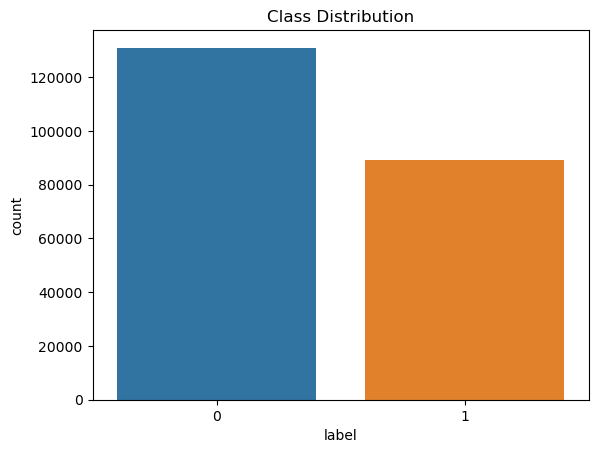

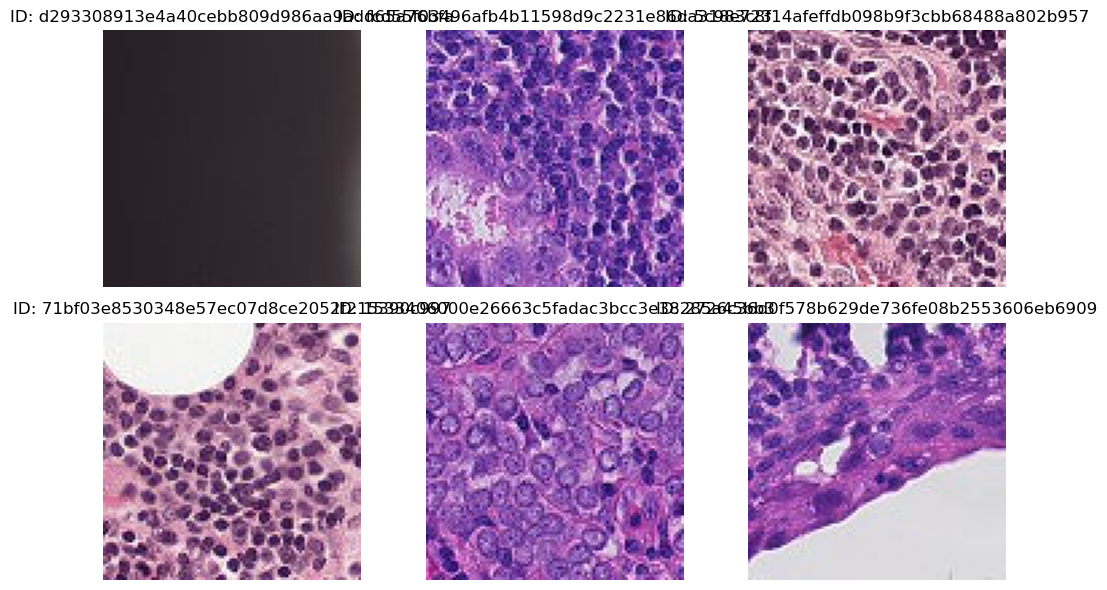

In [5]:
# Step 1: Data loading & EDA

train_df = pd.read_csv(LABELS_FILE)

# Basic info
print(train_df.head())
print(train_df.info())
print(train_df['label'].value_counts())

# Missing values
print("Missing values:\n", train_df.isnull().sum())

# Duplicates
dup_count = train_df.duplicated(subset=['id']).sum()
print(f"Duplicate IDs: {dup_count}")

# Class distribution plot
sns.countplot(x='label', data=train_df)
plt.title("Class Distribution")
plt.show()

# Show random samples
sample_ids = train_df.sample(6, random_state=42)['id'].values
plt.figure(figsize=(10,6))
for i, img_id in enumerate(sample_ids):
    img_path = TRAIN_DIR / f"{img_id}.tif"
    img = Image.open(img_path)
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"ID: {img_id}")
plt.tight_layout()
plt.show()


In [6]:
# Step 2: Train/Val split

from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['label'], random_state=42)


In [7]:
# Step 3: Data pipeline with PIL-based TIFF loader

def _read_with_pil(path_str):
    p = path_str.decode("utf-8")
    im = Image.open(p).convert("RGB")
    arr = np.array(im).astype(np.float32) / 255.
    return arr

def decode_image(path):
    img = tf.numpy_function(_read_with_pil, [path], tf.float32)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img

def get_label(label):
    return tf.cast(label, tf.float32)

def process_train(path, label):
    img = decode_image(path)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, 0.1)
    return img, get_label(label)

def process_val(path, label):
    img = decode_image(path)
    return img, get_label(label)

def build_ds(df, augment=False, shuffle=False):
    paths = [str(TRAIN_DIR / f"{id_}.tif") for id_ in df['id']]
    labels = df['label'].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.map(process_train if augment else process_val, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = build_ds(train_df, augment=True, shuffle=True)
val_ds   = build_ds(val_df)


In [8]:
# Step 4: CNN Model

from tensorflow.keras import layers, models

def build_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    return model

model = build_cnn()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])


Epoch 1/5

3095/3095 [==============================] - ETA: 0s - loss: 0.4205 - auc: 0.8831
Epoch 1: val_auc improved from -inf to 0.93365, saving model to best_model.h5
3095/3095 [==============================] - 1133s 366ms/step - loss: 0.4205 - auc: 0.8831 - val_loss: 0.3212 - val_auc: 0.9337 - lr: 0.0010
Epoch 2/5


C:\Users\Administrator\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3094/3095 [============================>.] - ETA: 0s - loss: 0.3299 - auc: 0.9294
Epoch 2: val_auc improved from 0.93365 to 0.94518, saving model to best_model.h5
3095/3095 [==============================] - 996s 322ms/step - loss: 0.3299 - auc: 0.9294 - val_loss: 0.3003 - val_auc: 0.9452 - lr: 0.0010
Epoch 3/5
3094/3095 [============================>.] - ETA: 0s - loss: 0.2969 - auc: 0.9429
Epoch 3: val_auc improved from 0.94518 to 0.95411, saving model to best_model.h5
3095/3095 [==============================] - 907s 293ms/step - loss: 0.2969 - auc: 0.9429 - val_loss: 0.3074 - val_auc: 0.9541 - lr: 0.0010
Epoch 4/5
3094/3095 [============================>.] - ETA: 0s - loss: 0.2755 - auc: 0.9506
Epoch 4: val_auc did not improve from 0.95411
3095/3095 [==============================] - 925s 299ms/step - loss: 0.2754 - auc: 0.9506 - val_loss: 0.2787 - val_auc: 0.9534 - lr: 0.0010
Epoch 5/5
3094/3095 [============================>.] - ETA: 0s - loss: 0.2603 - auc: 0.9558
Epoch 5: val_a

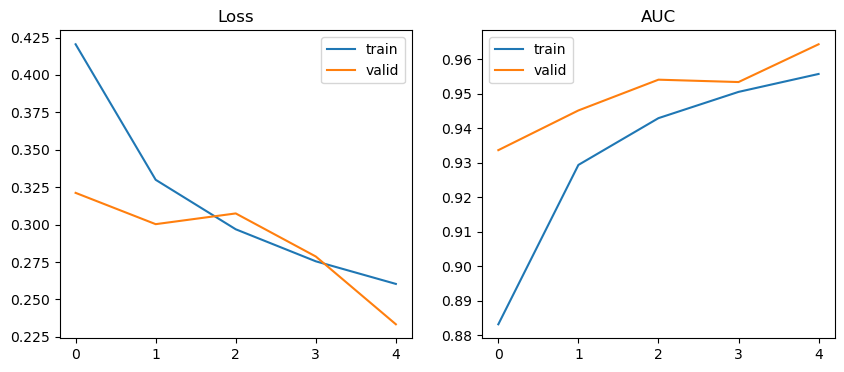

In [9]:
# Step 5: Training

# Callbacks: best model + early stop + LR scheduler
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5", save_best_only=True, monitor="val_auc", mode="max", verbose=1
)
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    patience=3, restore_best_weights=True, monitor="val_auc", mode="max", verbose=1
)
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_auc", mode="max", factor=0.3, patience=2, min_lr=1e-6, verbose=1
)

EPOCHS = 5

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb],
    verbose=1,
)

# Optional: quick curves
def plot_history(h):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(h["loss"], label="train")
    plt.plot(h["val_loss"], label="valid")
    plt.title("Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(h["auc"], label="train")
    plt.plot(h["val_auc"], label="valid")
    plt.title("AUC"); plt.legend()
    plt.show()

plot_history(history.history)

In [10]:
# Step 6: Evaluation on validation set

# Build a small tensor batch for validation evaluation (RAM-permitting).
# If RAM is tight, do this in batches with tf.data similar to test_ds below.
val_paths = (TRAIN_DIR / (val_df['id'] + ".tif")).astype(str).tolist()

def build_val_ds(paths):
    ds = tf.data.Dataset.from_tensor_slices(paths)
    ds = ds.map(lambda p: (decode_image(p),), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

val_ds_pred = build_val_ds(val_paths)
val_probs = model.predict(val_ds_pred).ravel()
val_true  = val_df['label'].values

print("Validation ROC AUC:", roc_auc_score(val_true, val_probs))

thr = 0.5
val_pred_cls = (val_probs >= thr).astype(int)
print(classification_report(val_true, val_pred_cls, digits=4))

344/344 [==============================] - 39s 113ms/step
Validation ROC AUC: 0.9645149760953811
              precision    recall  f1-score   support

           0     0.9168    0.9276    0.9222     13091
           1     0.8918    0.8763    0.8840      8912

    accuracy                         0.9068     22003
   macro avg     0.9043    0.9020    0.9031     22003
weighted avg     0.9067    0.9068    0.9067     22003



In [12]:
# Step 7: Predict on test set & submission
SAMPLE_SUB_FILE = DATA_DIR / "sample_submission.csv"

# -- ensure we use the best weights saved during training
model.load_weights("best_model.h5")   # 如果已使用 EarlyStopping(restore_best_weights=True)，这行可有可无，但加上更稳

# -- read sample submission (has only an 'id' column)
sample_sub = pd.read_csv(SAMPLE_SUB_FILE)
sample_sub['id'] = sample_sub['id'].astype(str)

# -- build absolute file paths for test images (.tif)
test_paths = [str(TEST_DIR / f"{_id}.tif") for _id in sample_sub['id']]

# -- tf.data pipeline for test
def build_test_ds(paths):
    ds = tf.data.Dataset.from_tensor_slices(paths)
    ds = ds.map(lambda p: (decode_image(p),), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

test_ds   = build_test_ds(test_paths)
test_probs = model.predict(test_ds).ravel()


# test_probs = np.clip(test_probs, 1e-6, 1 - 1e-6)

# -- make submission
submission = sample_sub.copy()
submission['label'] = test_probs

save_path = DATA_DIR / "submission_cnn.csv"
submission.to_csv(save_path, index=False)
print("Saved submission to:", save_path)
print(submission.head())

898/898 [==============================] - 163s 181ms/step
Saved submission to: D:\AI\CU-AI\Vicky\Class 3\W3\submission_cnn.csv
                                         id     label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5  0.001365
1  95596b92e5066c5c52466c90b69ff089b39f2737  0.002412
2  248e6738860e2ebcf6258cdc1f32f299e0c76914  0.005586
3  2c35657e312966e9294eac6841726ff3a748febf  0.076267
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6  0.133299


In [13]:
import pandas as pd, numpy as np, os
sub = pd.read_csv(DATA_DIR / "submission_cnn.csv")
print(sub.head())
print("shape:", sub.shape)                      # 应该是 (220003, 2)
print("columns:", list(sub.columns))            # 应该是 ['id','label']
print("prob range:", float(sub.label.min()), float(sub.label.max()))  # 应在 [0,1]
print("has_na:", sub.isna().sum().to_dict())
print("unique ids == rows:", sub['id'].nunique() == len(sub))
print("file size (MB):", os.path.getsize(DATA_DIR / "submission_cnn.csv")/1024/1024)

                                         id     label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5  0.001365
1  95596b92e5066c5c52466c90b69ff089b39f2737  0.002412
2  248e6738860e2ebcf6258cdc1f32f299e0c76914  0.005586
3  2c35657e312966e9294eac6841726ff3a748febf  0.076267
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6  0.133299
shape: (57458, 2)
columns: ['id', 'label']
prob range: 1.9218598e-08 1.0
has_na: {'id': 0, 'label': 0}
unique ids == rows: True
file size (MB): 2.9142208099365234


Training Curve and AUC Progression
The model was trained for 5 epochs in a CPU-only environment. The validation AUC increased steadily from ~0.88 (Epoch 1) to ~0.93 (Epoch 2) and ~0.95 (Epoch 3), after which it showed minor fluctuations while remaining stable in the 0.95–0.96 range. The highest validation AUC was observed between Epochs 2–5 (as shown in the training logs and plots), demonstrating the typical pattern of “rapid improvement in the early epochs followed by performance stabilization.”

Rationale for Training Only 5 Epochs
Given that the experiment was conducted on a CPU environment (without GPU acceleration), each epoch incurred a considerable training time cost. Observations showed that AUC improved significantly during Epochs 2–3, with diminishing returns thereafter. Therefore, limiting training to 5 epochs was chosen based on:

Performance stability – Achieving reproducible and stable validation AUC (~0.95+) within a small number of epochs;

Time efficiency – Keeping training duration manageable for rapid experimentation and timely submission;

Result reliability – Using the ModelCheckpoint(monitor='val_auc', save_best_only=True) callback ensures that the model with the best validation AUC is preserved for inference and final submission, even if later epochs show performance fluctuations.